In [126]:
#https://www.tensorflow.org/guide/keras/rnn
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
drive.mount('/content/gdrive')
url = "gdrive/Shareddrives/CPSC 4176 Project Spring 2023/Code/NormalizedDataExcelFile/UAV_4_Data_down_Cleaned.xlsx"
data = pd.read_excel(url)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [127]:
vehicleIDs = []
for x in data['VehicleID']:
  vehicleIDs.append(x)
vehicleIDs = sorted(list(set(vehicleIDs)))

import random
vehicle_data = data.loc[data['VehicleID'] == random.choice(vehicleIDs)]

normalized_data = pd.DataFrame()
normalized_data['VehicleID'] = vehicle_data['VehicleID']
normalized_data['Time(s)'] = (vehicle_data['Time(s)'] - vehicle_data['Time(s)'].min()) / (vehicle_data['Time(s)'].max() - vehicle_data['Time(s)'].min())
normalized_data['x-axis position(m)'] = (vehicle_data['x-axis position(m)'] - vehicle_data['x-axis position(m)'].min()) / (vehicle_data['x-axis position(m)'].max() - vehicle_data['x-axis position(m)'].min())
normalized_data['Distance from upper Lane line(m) 	'] = (vehicle_data['Distance from upper Lane line(m)'] - vehicle_data['Distance from upper Lane line(m)'].min()) / (vehicle_data['Distance from upper Lane line(m)'].max() - vehicle_data['Distance from upper Lane line(m)'].min())
normalized_data['Distance from lower lane line(m)'] = (vehicle_data['Distance from lower lane line(m)'] - vehicle_data['Distance from lower lane line(m)'].min()) / (vehicle_data['Distance from lower lane line(m)'].max() - vehicle_data['Distance from lower lane line(m)'].min())
normalized_data['Speed(m/s)'] = (vehicle_data['Speed(m/s)'] - vehicle_data['Speed(m/s)'].min()) / (vehicle_data['Speed(m/s)'].max() - vehicle_data['Speed(m/s)'].min())
normalized_data['Acceleration(m/s^2)'] = (vehicle_data['Acceleration(m/s^2)'] - vehicle_data['Acceleration(m/s^2)'].min()) / (vehicle_data['Acceleration(m/s^2)'].max() - vehicle_data['Acceleration(m/s^2)'].min())
normalized_data['VehicleLength(meter)'] = (vehicle_data['VehicleLength(meter)'] - vehicle_data['VehicleLength(meter)'].min()) / (vehicle_data['VehicleLength(meter)'].max() - vehicle_data['VehicleLength(meter)'].min())
normalized_data['VehicleWidth(meter)'] = (vehicle_data['VehicleWidth(meter)'] - vehicle_data['VehicleWidth(meter)'].min()) / (vehicle_data['VehicleWidth(meter)'].max() - vehicle_data['VehicleWidth(meter)'].min())

In [128]:
normalized_data

,VehicleID,Time(s),x-axis position(m),Distance from upper Lane line(m) \t,Distance from lower lane line(m),Speed(m/s),Acceleration(m/s^2),VehicleLength(meter),VehicleWidth(meter)
386071,12618,0.000000,0.000000,1.000000,0.000000,0.000000,0.999177,NaN,NaN
386072,12618,0.002451,0.002170,0.998480,0.002053,0.009221,0.985714,NaN,NaN
386073,12618,0.004902,0.004344,0.996895,0.004170,0.018299,0.985714,NaN,NaN
386074,12618,0.007353,0.006521,0.995261,0.006338,0.027376,0.971429,NaN,NaN
386075,12618,0.009804,0.008702,0.993546,0.008585,0.036309,0.957143,NaN,NaN
...,...,...,...,...,...,...,...,...,...
386475,12618,0.990196,0.989880,0.039778,0.970118,0.998355,0.156228,NaN,NaN
386476,12618,0.992647,0.992410,0.040769,0.969508,0.999066,0.081757,NaN,NaN
386477,12618,0.995098,0.994940,0.041751,0.968905,0.999027,0.154335,NaN,NaN
386478,12618,0.997549,0.997470,0.042752,0.968284,0.999719,0.113609,NaN,NaN


In [129]:
column_indices = {name: i for i, name in enumerate(normalized_data_s.columns)}

n = len(normalized_data)
train_df = normalized_data[0:int(n*0.7)]
val_df = normalized_data[int(n*0.7):int(n*0.9)]
test_df = normalized_data[int(n*0.9):]

num_features = normalized_data.shape[1]

In [130]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [131]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [132]:
def plot(self, model=None, plot_col='Speed(m/s)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [0.0333 seconds]')

WindowGenerator.plot = plot

In [133]:
Example1 = WindowGenerator(
    input_width=6, label_width=1, shift=1, label_columns=['Speed(m/s)'])
Example1

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Speed(m/s)']

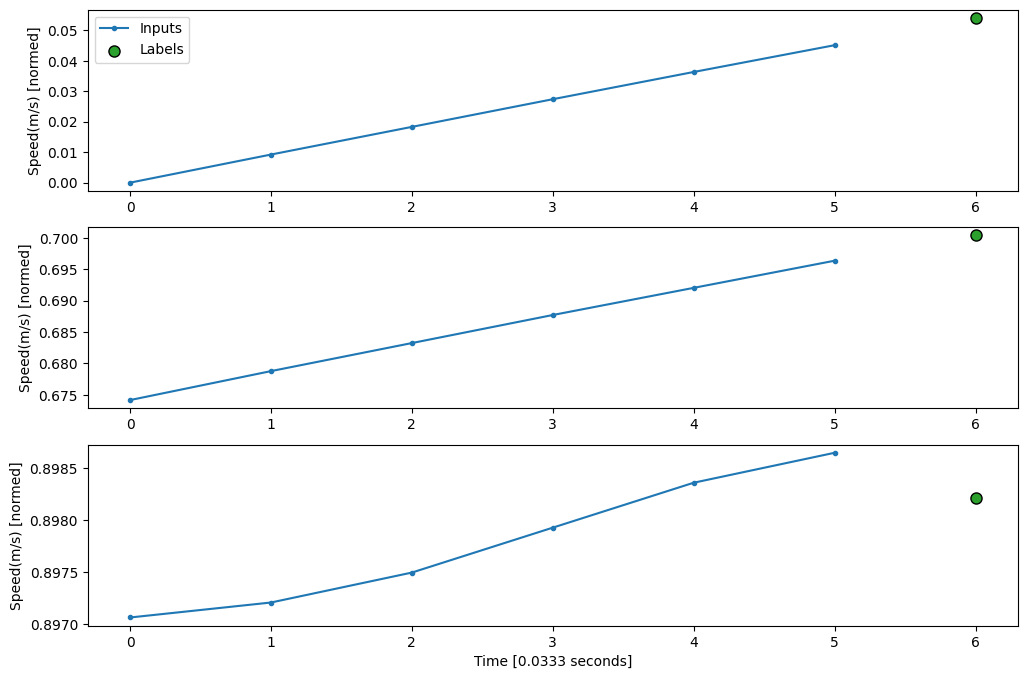

In [134]:
example_window = tf.stack([np.array(train_df[:Example1.total_window_size]),
                           np.array(train_df[100:100+Example1.total_window_size]),
                           np.array(train_df[200:200+Example1.total_window_size])])

example_inputs, example_labels = Example1.split_window(example_window)
Example1.example = example_inputs, example_labels

Example1.plot()

In [135]:
Example2 = WindowGenerator(
    input_width=24, label_width=1, shift=24, label_columns=['Speed(m/s)'])
Example2

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Speed(m/s)']

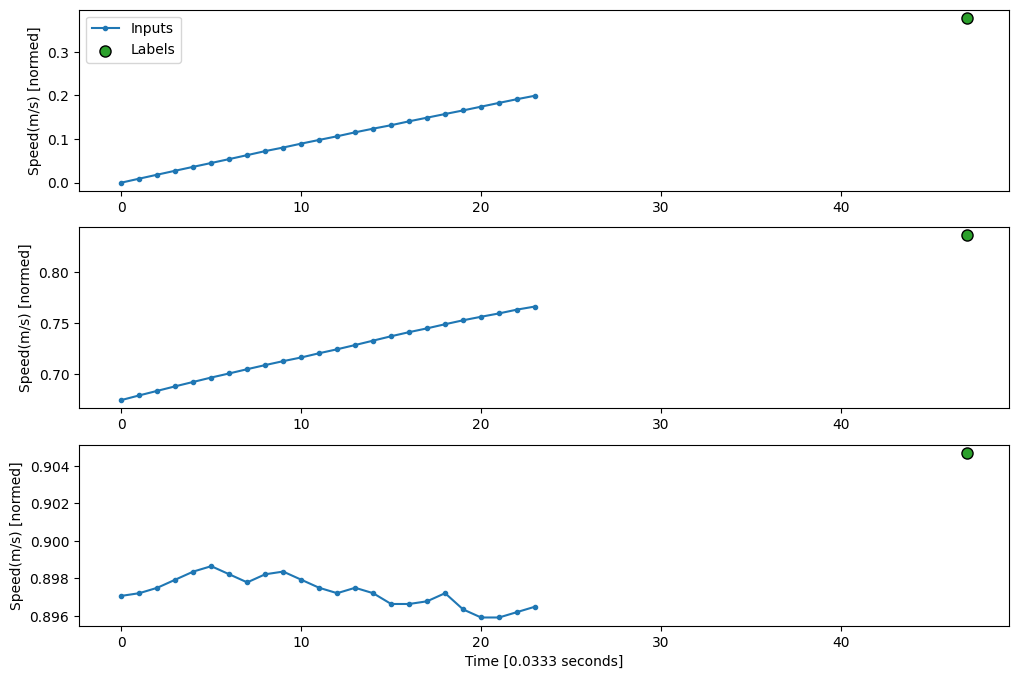

In [136]:
example_window = tf.stack([np.array(train_df[:Example2.total_window_size]),
                           np.array(train_df[100:100+Example2.total_window_size]),
                           np.array(train_df[200:200+Example2.total_window_size])])

example_inputs, example_labels = Example2.split_window(example_window)
Example2.example = example_inputs, example_labels

Example2.plot()

In [137]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [138]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train))
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [139]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['Speed(m/s)'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Speed(m/s)']

In [140]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [141]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [142]:
baseline = Baseline(label_index=column_indices['Speed(m/s)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline SS'] = baseline.evaluate(single_step_window.val)
performance['Baseline SS'] = baseline.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 4ms/step - loss: 159189216.0000 - mean_absolute_error: 12617.0205


In [143]:
wide_window = WindowGenerator(
    input_width=50, label_width=50, shift=1, label_columns=['Speed(m/s)'])

wide_window

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Label column name(s): ['Speed(m/s)']

In [144]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 50, 9)
Output shape: (32, 50, 1)


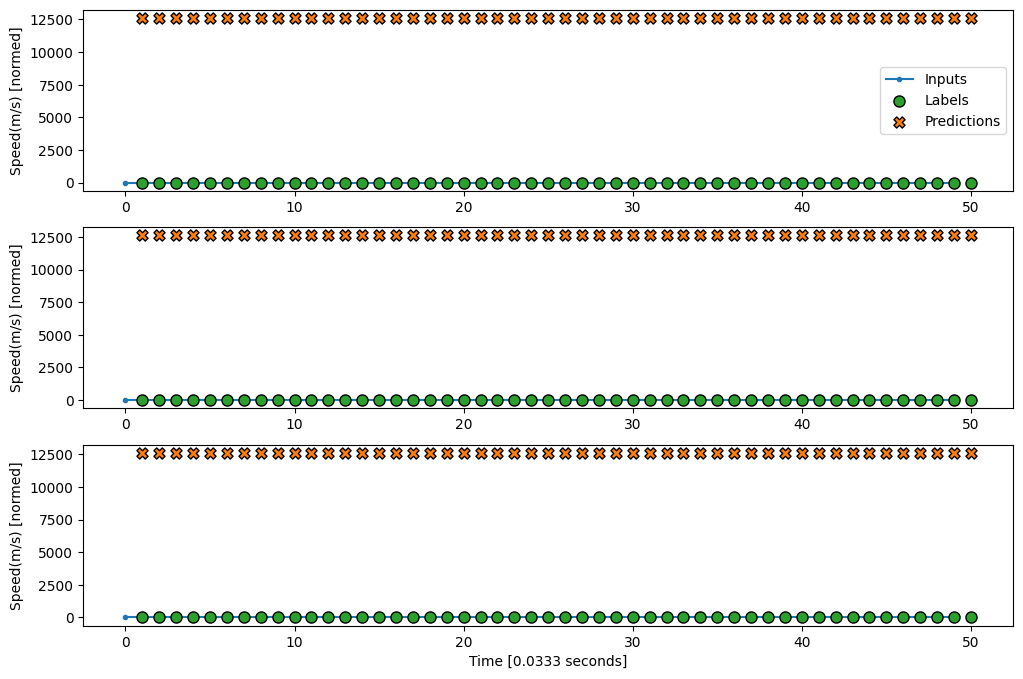

In [145]:
wide_window.plot(baseline)

In [146]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [147]:
#linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])
linear = keras.Sequential()
linear.add(layers.Embedding(input_dim = 1000, output_dim = 64))
linear.add(layers.LSTM(128))
linear.add(layers.Dense(units=1))
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 9)


InvalidArgumentError: ignored

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear SS'] = linear.evaluate(single_step_window.val)
performance['Linear SS'] = linear.evaluate(single_step_window.test, verbose=0)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(linear)

In [ ]:
model2 = keras.Sequential()
model2.add(layers.Embedding(input_dim=1000, output_dim=64))
model2.add(layers.GRU(256, return_sequences = True))
model2.add(layers.SimpleRNN(128))
model2.add(layers.Dense(10))
model2.summary()

In [ ]:
encoder_vocab = 1000
decoder_vocab = 2000
encoder_input = layers.Input(shape = (None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim = 64)(encoder_input)
output, state_h, state_c = layers.LSTM(64, return_state = True, name = "encoder")(encoder_embedded)
encoder_state = [state_h, state_c]
decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim = 64)(decoder_input)
decoder_output = layers.LSTM(64, name = "decoder")(decoder_embedded, initial_state=encoder_state)
output = layers.Dense(10)(decoder_output)
model3 = keras.Model([encoder_input, decoder_input], output)
model3.summary()

In [ ]:
#Bidirectional Model
model4 = keras.Sequential()
model4.add(layers.Bidirectional(layers.LSTM(64, return_sequences = True), input_shape = (5, 10)))
model4.add(layers.Bidirectional(layers.LSTM(32)))
model4.add(layers.Dense(10))
model4.summary()